# Plane wall

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cghiaus/var_cond/HEAD?labpath=notebooks%2F03_wall_steady.ipynb)

Let's consider a plane wall with variable conductivity included into a more complex model.  In this case, the surface temperatures are unknowns of the thermal network.

The __iterative method__ proposed for the case of variable conductivity is:

- Initially, consider conductances $G_{w0}$ in the wall calculated with conductivity $\lambda_0.$

- Assemble the thermal circuits considering $G_{w0}$: $G = \mathrm{diag} ([G_0, ..., G_{w0}, ..., G_n])$.

- Estimate initial temperature distribution in the thermal network:

$$
\theta_0 = (A^T G A)^{-1}(A^T G b + f)
$$

- __While__ $\left \| \varepsilon \right \|_\infty > \varepsilon_{admitted}$:
    - mean temperature $\bar \theta = f(\theta_0)$ for linear or quadratic model
    - conductances in the wall $G_w = \frac{1}{w/n_b} \lambda_0 (1 + \beta \bar \theta)$
    - temperatures in the circuit $\theta = (A^T G A)^{-1}(A^T G b + f)$
    - error between iterrations 
$\left \| \varepsilon \right \|_\infty ≡ \mathrm{max}(|\theta - \theta_0|)$
    - new temperature distribution $\theta_0 \leftarrow  \theta$
- flow-rates in the circuit $q = G (-A \theta + b)$

In order to exemplify this algorithm, let's consider a wall with convection and irradiance on both surfaces (Figure 1). The examples are for two material, fiberglass and polyisocyanurate, which have linear and quadratic models for conductivity, respectively.

![therm_circ](./figures/var_cond_wall.svg)
> Figure 1. Plane wall with convection and flow-rate sources.

In [1]:
import numpy as np
import sys
sys.path.append('../src')  # Add 'src' directory to the system path
import var_cond

## Linear model

The simulation consists in:

- From the linear (polynomial) model 
$$
\lambda = a T + b
$$

obtain the cannonical conductivity model.

$$
\lambda = \lambda_0(1 + \beta (T - T_b))
$$

- Numerically solve the thermal circuit for the wall.

- By using the temperatures for the surface of the wall fond numerically, solve analitically the Dirichelet problem.

- Plot on the same graph the temperature dstribution obtained numerically and analytically, and the line between the surface temperatures.

In [2]:
def sim_Fiberglass(width, mesh, air_temp, flow_surf, conv_coef, Tb):  
    # data linear model
    deg = 1

    a, b = 0.0002, 0.04         # fitted λ(T) = a * T + b

    # Model λ(T) = a*T + b to λ(T) = λ0 * (1 + β * (T - Tb))
    λ0, β, θ0 = var_cond.poly2model([a, b], Tb, deg)
    conductivity_model = [λ0, β, Tb, deg]

    θ, q, x = var_cond.wall_num(conductivity_model, width, mesh,
                                air_temp, flow_surf, conv_coef)
    x_w, θ_w = x[1:-1], θ[1:-1]     # wall

    surf_temp = θ[0], θ[-1]

    # Analytical solution
    θ_a, q_a, x_a = var_cond.dirichlet_anal(conductivity_model, width,
                                            surf_temp, num=5)

    var_cond.wall_plot(x, θ, x_a, θ_a, air_temp, material='Fiberglass');
    
    return q, conductivity_model, [θ[0], θ[-1]]

Let's consider the fiberglass wall for wich we can modify the width, the number of meshes for discretisation, the air temperatures, the irradiances and the convection coefficients on both sides of the wall, and the base temperature in the model of conductivity.

In [3]:
# Data
width = 0.20                # m, width of the plane wall in number of meshes
mesh = 3                    # number of meshes, mesh > 2
air_temp = -20, 20          # °C, air temperatures outdoor; indoor
flow_surf = 0, 0            # W/m², flow on surfaces outdoor, indoor
conv_coef = 8, 25           # W/(m·K²), convection coefficients outdoor, indoor

### Influence of base temperature

The flow rate through the wall in the case of constant conductivity and no flow rate sources on the surfaces is:

$$
q_m = U \Delta T
$$

where:
- $U = \frac{1}{\frac{1}{h_0} + \frac{w}{\lambda} + \frac{1}{h_1}}$ - global conductivity, W/(m²·K);
- $\Delta T = T_0 - T_1$ - temperature difference, °C.

For a base temperature $T_b$ = 20 °C, the relative error between using the numerical method or considering constant conductivity $\lambda_0$ is about 10 %.

Base temperature: 		 20.0 °C
Flow rate (numerical): 		 -7.76 W/m²
Flow rate with constant λ0: 	 -8.49 W/m²
Relative error: 		 9.47 %


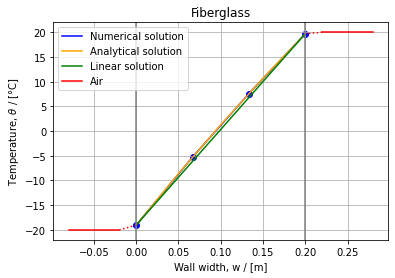

In [4]:
Tb = 20                     # °C, mean (base) temperature

q, conductivity_model, [T0, T1]  = sim_Fiberglass(width, mesh, air_temp, flow_surf, conv_coef, Tb)
λ0, β, Tb, deg = conductivity_model

U = 1 /(1 / conv_coef[0] + width / λ0 + 1 / conv_coef[1])
q_m = -U * np.diff(air_temp)

ε = (q_m - q[0]) / q[0]
print(f'Base temperature: \t\t {Tb:.1f} °C')
print(f'Flow rate (numerical): \t\t {q[0]:.2f} W/m²')
print(f'Flow rate with constant λ0: \t {q_m[0]:.2f} W/m²')
print(f'Relative error: \t\t {ε[0]*100:.2f} %')

> Figure 2. Temperature distribution in a wall with linear thermal conductivity in the case of no irradiation of the surfaces. $T_b$ = 20 °C.

If the base temperature is the mean of air temperatures, the relative error is small.

Base temperature: 		 0.0 °C
Flow rate (numerical): 		 -7.76 W/m²
Flow rate with constant λ0: 	 -7.74 W/m²
Relative error: 		 -0.16 %


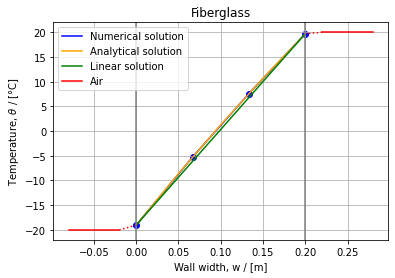

In [5]:
Tb = 0
q, conductivity_model, [T0, T1] = sim_Fiberglass(width, mesh, air_temp, flow_surf, conv_coef, Tb)
λ0, β, Tb, deg = conductivity_model

U = 1 /(1 / conv_coef[0] + width / λ0 + 1 / conv_coef[1])
q_m = -U * np.diff(air_temp)

ε = (q_m - q[0]) / q[0]
print(f'Base temperature: \t\t {Tb:.1f} °C')
print(f'Flow rate (numerical): \t\t {q[0]:.2f} W/m²')
print(f'Flow rate with constant λ0: \t {q_m[0]:.2f} W/m²')
print(f'Relative error: \t\t {ε[0]*100:.2f} %')

> Figure 3. Temperature distribution in a wall with linear thermal conductivity in the case of no irradiation of the surfaces. $T_b$ = 0 °C.

Base temperature: 		 0.3 °C
Flow rate (numerical): 		 -7.76 W/m²
Flow rate with constant λ0: 	 -7.76 W/m²
Relative error: 		 -0.00 %


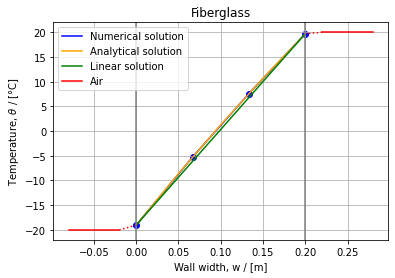

In [6]:
Tb = (T0 + T1) / 2
q, conductivity_model, [T0, T1]  = sim_Fiberglass(width, mesh, air_temp, flow_surf, conv_coef, Tb)
λ0, β, Tb, deg = conductivity_model

U = 1 /(1 / conv_coef[0] + width / λ0 + 1 / conv_coef[1])
q_m = -U * np.diff(air_temp)

ε = (q_m - q[0]) / q[0]
print(f'Base temperature: \t\t {Tb:.1f} °C')
print(f'Flow rate (numerical): \t\t {q[0]:.2f} W/m²')
print(f'Flow rate with constant λ0: \t {q_m[0]:.2f} W/m²')
print(f'Relative error: \t\t {ε[0]*100:.2f} %')

> Figure 4. Temperature distribution in a wall with linear thermal conductivity in the case of no irradiation of the surfaces. $T_b = (T_0 + T_1) / 2$.

### Influence of irradiance absorbed by the surfaces

The thermal circuit for the case of constant conductivity of the wall and flow rate sources on the surfaces is shown in Figure 6.

![therm_circ](./figures/const_cond_wall.svg)
> Figure 5. Plane wall with convection and flow-rate sources in the case of constant conductivity.

Base temperature: 		 20.0 °C
Flow rate (numerical): 		 -105.92 W/m²
Flow rate with constant λ0: 	 -106.26 W/m²
Relative error: 		 0.32 %


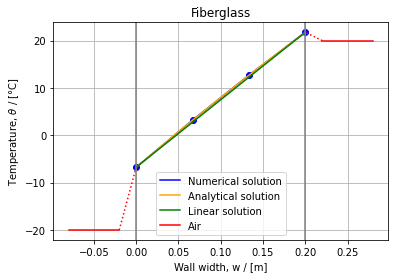

In [7]:
Tb = 20
air_temp = -20, 20
flow_surf = 100, 50 

q, conductivity_model, [T0, T1]  = sim_Fiberglass(width, mesh, air_temp, flow_surf, conv_coef, Tb)
λ0, β, Tb, deg = conductivity_model

A = np.array([[1, 0],
              [-1, 1],
              [0, -1]])
G = np.diag([conv_coef[0], λ0 / width, conv_coef[1]])
b = np.array([air_temp[0], 0, -air_temp[1]])
f = np.array([flow_surf[0], flow_surf[1]])

θ_m = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
q_m = G @ (-A @ θ_m + b)

ε = (q_m - q[0]) / q[0]
print(f'Base temperature: \t\t {Tb:.1f} °C')
print(f'Flow rate (numerical): \t\t {q[0]:.2f} W/m²')
print(f'Flow rate with constant λ0: \t {q_m[0]:.2f} W/m²')
print(f'Relative error: \t\t {ε[0]*100:.2f} %')